## W6 Decision Trees

### Load Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Credit scoring data
* https://github.com/gastonstat/CreditScoring

### 6.1 Cleaning & preparation
* Downloading the dataset
* Re-enconding the categorical variables
* train-validation-test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

--2022-10-14 09:47:55--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.06s   

2022-10-14 09:47:55 (2.98 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [4]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv(data)
df.columns = df.columns.str.lower()
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
status_values = {
    1: "ok",
    2: "default",
    0: "unk"
}
df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [9]:

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [15]:
del df_train['status']
del df_val['status']
del df_test['status']

In [16]:
df_train.sample()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
2576,36,owner,60,51,married,no,fixed,35,205.0,4000.0,0.0,950,1017


### 6.2 Decision trees
* How a decision tree looks like
* Training
* Overfitting
* Controlling the size of a tree

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()

In [19]:
assess_risk(xi)

'ok'

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(dt)

DecisionTreeClassifier()


In [24]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.643384756968831

In [26]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [27]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
print(dt)

DecisionTreeClassifier(max_depth=2)


In [28]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [29]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



/home/nenomius/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 6.3 Decision tree learning algorithm
* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [30]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [31]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [32]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [33]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


In [34]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [35]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [36]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [37]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [38]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

#####################


### 6.5 Decision trees parameter tuning
* selecting max_depth
* selecting min_samples_leaf

In [39]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.745
  10 -> 0.695
  15 -> 0.648
  20 -> 0.646
None -> 0.657


In [40]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [41]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [42]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.751
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.786
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

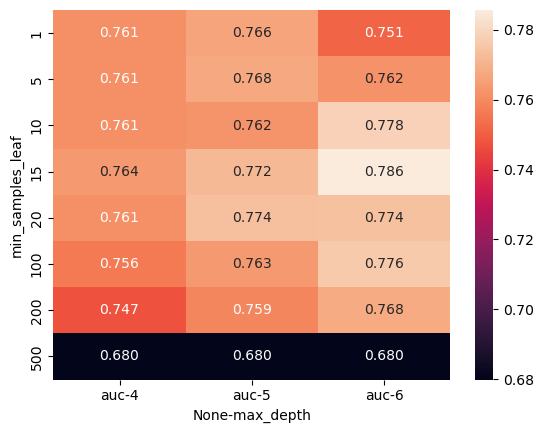

In [43]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [44]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)
print(dt)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)


In [45]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

/home/nenomius/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 6.6 Ensembles & random forest
* Board of experts
* Ensembling models
* Random forest - ensembling decision trees
* Tuning random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))


In [48]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

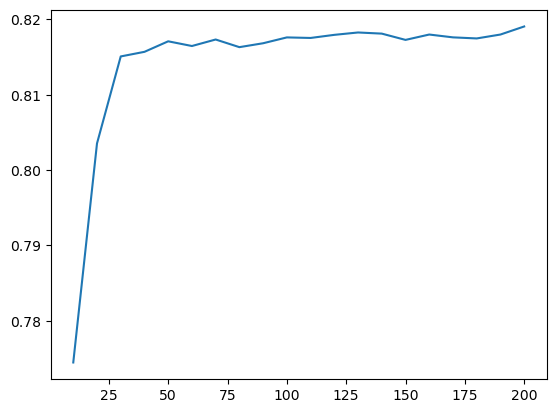

In [49]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [50]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [51]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

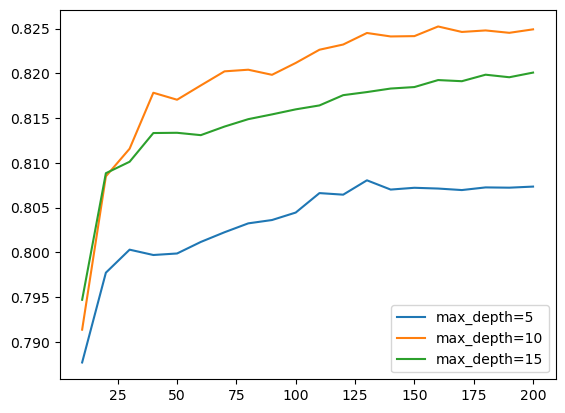

In [52]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [53]:
max_depth = 10

In [54]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [55]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

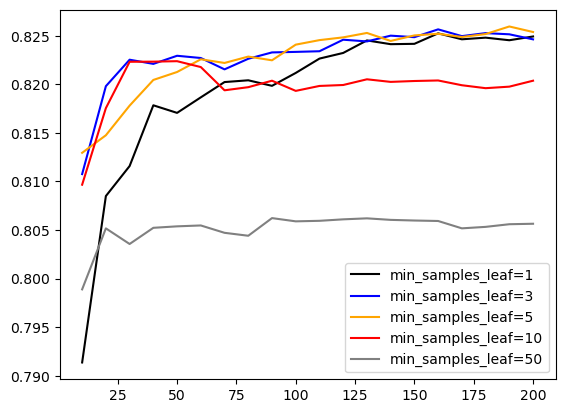

In [56]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [57]:
min_samples_leaf = 3

In [58]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)
print(rf)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)


### 6.7 Gradient boosting & XGBoost
* Gradient boosting vs random forest
* Installing XGBoost
* Training the forst model
* Performance monitoring
* Parsing xgboosts's monitoring output

In [59]:
import xgboost as xgb

In [60]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/home/nenomius/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [62]:
y_pred = model.predict(dval)

In [63]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [64]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [65]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [66]:
s = output.stdout

In [67]:
print(s[:200])

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	tr


In [68]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [69]:
df_score = parse_xgb_output(output)

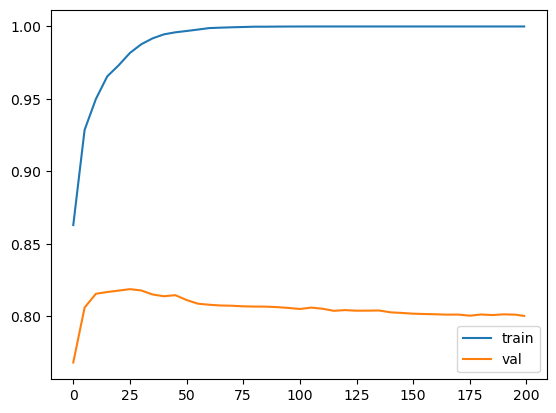

In [70]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

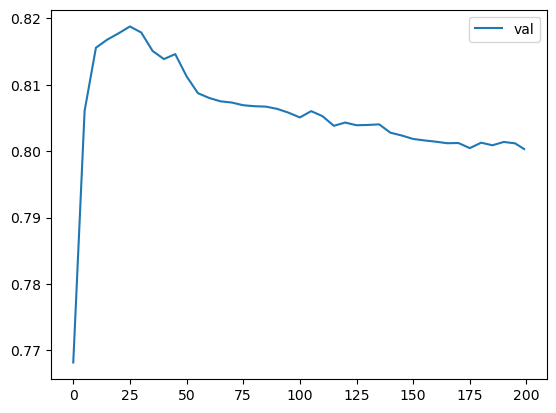

In [71]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### 6.8 XGBoost parameter tuning
Tuning the following parameters:
* eta
* max_depth
* min_child_weight

In [93]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [94]:
scores = {}

In [95]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [100]:
scores = {}

In [107]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [108]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [109]:
del scores['max_depth=10']

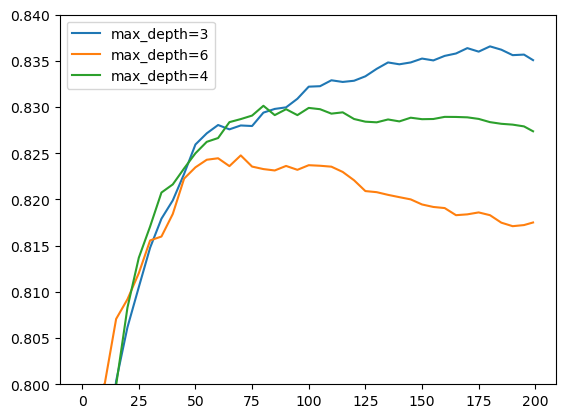

In [110]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [111]:
scores = {}

In [116]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [117]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

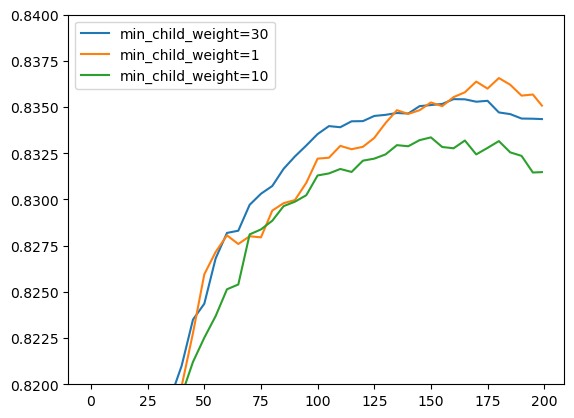

In [118]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [119]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:
* subsample and colsample_bytree
* lambda and alpha

### 6.9 Selecting the final model
* choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [121]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)
print(dt)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)


In [122]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.785470804775859

In [123]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)
print(rf)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)


In [124]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [125]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [126]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

In [127]:
df_full_train = df_full_train.reset_index(drop=True)

In [128]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [129]:
del df_full_train['status']

In [130]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [131]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

/home/nenomius/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [132]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [133]:
y_pred = model.predict(dtest)

In [134]:
roc_auc_score(y_test, y_pred)

0.8322662626460096